# Landsat-Daten: Erkunden und Herunterladen mit landsatxplore

**landsatxplore** ist eine Python-Bibliothek, die für das Suchen und Herunterladen von Landsat-Bildern von der USGS EarthExplorer-Plattform entwickelt wurde. Sie ermöglicht es Benutzern, Landsat-Datensätze nach verschiedenen Parametern wie Standort, Datum und Bewölkungsgrad abzufragen und die entsprechenden Bilder herunterzuladen. Dieses Tool vereinfacht den Zugriff auf und die Arbeit mit Satellitenbildern für Analyse und Visualisierung in Python.

**Informationen zur Bibliothek:**
* Bibliothek: landsatxplore
* Autor: str.ucture GmbH
* Notebook-Version: 1.3 (Aktualisiert: 10. Januar 2024)

Während die Bibliothek Open-Source ist, hat sie mehrere Einschränkungen:
* Satellitenbilder werden als **.tar**-Dateien heruntergeladen, wobei jedes Band als separates GeoTIFF gespeichert wird.
* Es fehlt an Funktionalität, um Bilder nach Bounding Box zu filtern oder zuzuschneiden, was zusätzliche Nachbearbeitung erfordert.
* Veraltet (letztes Update vor 3 Jahren); die Installation könnte andere Bibliotheken stören. Verwenden Sie `pip install --upgrade libraryName`, falls Probleme auftreten.

## 1. Festlegen der Pfade und Arbeitsverzeichnisse

In [1]:
import os

''' ---- Verzeichnisse hier angeben ---- '''
download_folder = r".\data\landsatxplorer\download"
working_folder = r".\data\landsatxplorer\working"
geotiff_folder = r".\data\landsatxplorer\geotiff"
csv_folder = r".\data\landsatxplorer\csv"
output_folder = r".\data\landsatxplorer\output"
''' ----- Ende der Angaben ---- '''

# Create directories if they do not exist
os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Filtern und Abrufen von Satellitenbild-Metadaten

### 2.1 API und Authentifizierung

Um sich bei der USGS-API zu authentifizieren, folgen Sie diesen Schritten:

1. **Registrieren**: Erstellen Sie ein Konto auf der [USGS-Registrierungsseite](https://ers.cr.usgs.gov/register/).
2. **Erhalten Sie die Anmeldedaten**: Nach der Registrierung gehen Sie zu **„Application Tokens“** und klicken Sie auf **„Create Application Token“**.  
   - Wählen Sie einen Namen für das Token und setzen Sie ein Ablaufdatum.  
   - Stellen Sie sicher, dass **M2M API** ausgewählt ist.  
   - Sobald das Token erstellt wurde, kopieren Sie es und speichern Sie es sicher, da es nach **60 Sekunden** nicht mehr sichtbar ist.

#### **Beispiel**:
Die `*.json`-Datei sollte folgendes Format haben:

```json
{
    "username": "your_username",
    "token": "your_token"
}

----

* **Wichtig**: Aufgrund von Änderungen im Authentifizierungsprozess bei USGS ist jetzt ein API-Token anstelle eines Passworts erforderlich. Da der ursprüngliche Mitwirkende landsatxplore nicht mehr pflegt, verwendet dieses Notebook ein anderes GitHub-Repository, in dem ein anderer Mitwirkender die notwendigen Authentifizierungsaktualisierungen implementiert hat.
* Um die funktionierende Version von landsatxplore zu installieren, führen Sie den folgenden Befehl aus:
* ``pip install git+https://github.com/jsearcy1/landsatxplore.git``

----

In [2]:
import json
from landsatxplore.api import API

# Laden Sie die Anmeldedaten aus der lokalen JSON-Datei
with open(r"D:/usgs.json", "r") as file:
    credentials = json.load(file)

username = credentials["username"]
token = credentials["token"]

### 2.2 Definieren der Abfrageparameter für die Daten

In [3]:
# Definieren des Datensatznamens und der Suchparameter
# Der Datensatzname und die Datensatz-ID können unter https://github.com/yannforget/landsatxplore gefunden werden
dataset = 'landsat_ot_c2_l2'
latlon = [47.6780, 9.1737]  # Konstanz
start_date = '2020-01-01'
end_date = '2020-10-01'
max_cloud_cover = 10

### 2.2 Suche nach verfügbaren Szenen

In [4]:
# Authentifizieren Sie sich bei der USGS-API
api = API(username=username, password=token)

# Suche nach verfügbaren Szenen für den angegebenen Datensatz
scenes = api.search(
    dataset = dataset,
    latitude = latlon[0],
    longitude = latlon[1],
    start_date = start_date,
    end_date = end_date,
    max_cloud_cover = max_cloud_cover
)

# Ausgabe der Anzahl der gefundenen Szenen
print(f"{len(scenes)} Szenen gefunden.")

# Abmelden von der API
api.logout()

8 Szenen gefunden.


### 2.3 Erstellen eines Dictionaries zur Speicherung aller Szeneninformationen

In [5]:
import pandas as pd

# Konvertieren der Szenendaten in ein DataFrame
df = pd.DataFrame([
    {
        "entity_id": scene["entity_id"],
        "display_id": scene["display_id"],
        "acq_date": scene["acquisition_date"],
        "scene_cloud_cover": scene["scene_cloud_cover"],
        "land_cloud_cover": scene["land_cloud_cover"],
        # "image_quality": scene["image_quality"],  # Auskommentieren, falls benötigt
        # "day_night": scene["day-night_indicator"],  # Auskommentieren, falls benötigt
        "sun_azimuth": scene["sun_azimuth_l0ra"],  # Empfohlener Bereich: 90-270 Grad
        "sun_elevation": scene["sun_elevation_l0ra"]  # Empfohlener Bereich: 50-90 Grad
    }
    for scene in scenes
])

# Ändern der Pandas-Anzeigeoptionen
pd.set_option('display.max_colwidth', 15)

# Anzeige des DataFrames
df.head(8)

,entity_id,display_id,acq_date,scene_cloud_cover,land_cloud_cover,sun_azimuth,sun_elevation
0,LC819502720...,LC08_L2SP_1...,2020-09-12,9.18,9.18,156.215019,44.101558
1,LC819402720...,LC08_L2SP_1...,2020-08-20,5.51,5.51,149.829906,51.441079
2,LC819502720...,LC08_L2SP_1...,2020-08-11,8.02,8.02,147.421532,53.924649
3,LC819502720...,LC08_L2SP_1...,2020-06-24,3.12,3.12,141.817662,61.728886
4,LC819402720...,LC08_L2SP_1...,2020-06-01,5.08,5.08,144.886824,61.052324
5,LC819502720...,LC08_L2SP_1...,2020-05-07,1.80,1.80,149.179967,56.408805
6,LC819502720...,LC08_L2SP_1...,2020-04-05,2.01,2.01,152.809102,45.887567
7,LC819502720...,LC08_L2SP_1...,2020-01-16,1.56,1.56,159.999515,19.169424


### 2.3 Visualisierung der Szenen als Polygone auf einer Karte

In [6]:
import folium
from shapely import wkt
from matplotlib import pyplot as plt

# Definieren der Farbkarte mit normalisierten Indizes
cmap = plt.get_cmap("turbo", 20)

# Initialisieren der Folium-Karte mit einer Standardposition
m = folium.Map(location=[47.5, 8.0],
               zoom_start=7,
               height=450,
               scrollWheelZoom=False)

# Schleife durch die Szenen, um Polygone hinzuzufügen
for i, scene in enumerate(scenes):
    entity_id = scene['entity_id']
    entity_cc = scene['cloud_cover']
    polygon_wkt = scene["spatial_coverage"]

    # Parsen des Polygons aus dem WKT-String
    polygon = wkt.loads(polygon_wkt) if isinstance(polygon_wkt, str) else polygon_wkt

    # Generieren der Farbe basierend auf dem Index
    color = [int(c * 255) for c in cmap(i)[:3]]

    # Erstellen einer Feature-Gruppe für jede Szene
    polygon_fg = folium.FeatureGroup(name=f"ID: {entity_id} (CC: {entity_cc})")

    # Hinzufügen des Polygons zur Karte
    folium.Polygon(
        locations=[(lat, lon) for lon, lat in polygon.exterior.coords],
        color=f"rgb({color[0]}, {color[1]}, {color[2]})",
        fill=True,
        fill_opacity=0.1,
    ).add_to(polygon_fg)

    # Hinzufügen der Feature-Gruppe zur Karte
    polygon_fg.add_to(m)

# Hinzufügen der Layer-Steuerung und Anzeigen der Karte
folium.LayerControl().add_to(m)
m


### 2.5 Herunterladen der Szene(n) mit der Display-ID

In [7]:
from landsatxplore.earthexplorer import EarthExplorer

# Initialisieren von EarthExplorer
api = API(username=username, password=token)
ee = EarthExplorer(username, token)

# Definieren der Szenenkennung und des Download-Pfades
identifier = 'LC08_L2SP_195027_20200624_20200824_02_T1'
download_filename = f"{identifier}.tar"
download_filepath = os.path.join(download_folder, download_filename)

# Den Datensatz nur herunterladen, wenn er noch nicht heruntergeladen wurde
if not os.path.isfile(download_filepath):
    ee.download(identifier=identifier, output_dir=download_folder)
else:
    print(f"Der Datensatz {identifier} wurde bereits heruntergeladen. Download überspringen.")

# Abmelden von der API und EarthExplorer
api.logout()
ee.logout()

Der Datensatz LC08_L2SP_195027_20200624_20200824_02_T1 wurde bereits heruntergeladen. Download überspringen.


### 2.6 Extrahieren der TAR-Datei im Ordner

In [8]:
import tarfile

# Definieren des Extraktionsordner-Pfades
extract_folder = os.path.join(working_folder, identifier)
os.makedirs(extract_folder, exist_ok=True)

# Extrahieren der ZIP-Datei
try:
    if not os.listdir(extract_folder):
        with tarfile.open(download_filepath) as tar:
            tar.extractall(path=extract_folder)
            print(f"Dateien erfolgreich extrahiert nach: {extract_folder}")
    else:
        print("Ordner ist nicht leer. Extraktion wird übersprungen.")
except FileNotFoundError:
    print(f"Fehler: Die Datei {download_filepath} wurde nicht gefunden.")
except zipfile.BadZipFile:
    print(f"Fehler: Die Datei {download_filepath} ist keine gültige ZIP-Datei.")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

Ordner ist nicht leer. Extraktion wird übersprungen.


## 3. RGB-Bänder zu einer einzelnen GeoTIFF-Datei zusammenführen

### 3.1 Erstellen eines DataFrames aller verfügbaren Dateien

In [9]:
import re

# Extrahieren der Metadaten aus dem Dateinamen.
def meta(filename):
    return dict(
        filename=filename,
        path=os.path.join(extract_folder, filename),
        bandname=filename.replace(f"{identifier}_","").replace(".TIF", "")
    )

# Erstellen eines DataFrames aus der Liste der .TIF-Dateien im extrahierten Verzeichnis
file_list = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.TIF')]
df_files = pd.DataFrame.from_dict(file_list)

# Anzeige des DataFrames
df_files

,filename,path,bandname
0,LC08_L2SP_1...,.\data\land...,QA_PIXEL
1,LC08_L2SP_1...,.\data\land...,QA_RADSAT
2,LC08_L2SP_1...,.\data\land...,SR_B1
3,LC08_L2SP_1...,.\data\land...,SR_B2
4,LC08_L2SP_1...,.\data\land...,SR_B3
5,LC08_L2SP_1...,.\data\land...,SR_B4
6,LC08_L2SP_1...,.\data\land...,SR_B5
7,LC08_L2SP_1...,.\data\land...,SR_B6
8,LC08_L2SP_1...,.\data\land...,SR_B7
9,LC08_L2SP_1...,.\data\land...,SR_QA_AEROSOL


### 3.2 Definieren eines Dictionaries für die Zuordnung der Bandnamen

In [10]:
# Dictionary zur Zuordnung von Bandnamen zu deren Beschreibungen
band_descriptions = {
    'QA_PIXEL': 'Qualitätsbewertung der Pixel (allgemeine Qualitätsinformationen zu jedem Pixel)',
    'QA_RADSAT': 'Qualitätsbewertung für Rad-Sättigung',
    'SR_B1': 'Band 1: Küstennah/Aerosol (430-450 nm)',
    'SR_B2': 'Band 2: Blau (450-515 nm)',
    'SR_B3': 'Band 3: Grün (525-600 nm)',
    'SR_B4': 'Band 4: Rot (630-680 nm)',
    'SR_B5': 'Band 5: Nahes Infrarot (NIR) (850-880 nm)',
    'SR_B6': 'Band 6: Kurzwelliges Infrarot 1 (SWIR1) (1570-1650 nm)',
    'SR_B7': 'Band 7: Kurzwelliges Infrarot 2 (SWIR2) (2110-2290 nm)',
    'SR_QA_AEROSOL': 'Qualitätsbewertung für Aerosol (bezogen auf atmosphärische Bedingungen)',
    'ST_ATRAN': 'Atmosphärische Transmission (Fraktion der eingehenden Solarstrahlung)',
    'ST_B10': 'Band 10: Thermisches Infrarot 1 (TIR1) (10,60-11,19 µm)',
    'ST_CDIST': 'Wolkendistanz (Abstand zur nächsten Wolke)',
    'ST_DRAD': 'Radiance (Energie pro Flächeneinheit)',
    'ST_EMIS': 'Emissivität (bezogen auf die Oberflächentemperatur)',
    'ST_EMSD': 'Emissivitätsstandardabweichung',
    'ST_QA': 'Qualitätsbewertung für thermische Bänder',
    'ST_TRAD': 'Strahlende Temperatur (gemessen in Kelvin)',
    'ST_URAD': 'Aufsteigende Radiance (Energie, die von der Oberfläche ausgeht)'
}

# Ändern der Pandas-Anzeigeoptionen
pd.reset_option('display.max_colwidth')

# Zuordnen der Bandnamen zu den Beschreibungen und Erstellen einer neuen 'remarks'-Spalte
df_files['remarks'] = df_files['bandname'].map(band_descriptions)

# Nur relevante Spalten anzeigen
df_files.loc[:, df_files.columns.isin(['bandname', 'remarks'])]

,bandname,remarks
0,QA_PIXEL,Qualitätsbewertung der Pixel (allgemeine Quali...
1,QA_RADSAT,Qualitätsbewertung für Rad-Sättigung
2,SR_B1,Band 1: Küstennah/Aerosol (430-450 nm)
3,SR_B2,Band 2: Blau (450-515 nm)
4,SR_B3,Band 3: Grün (525-600 nm)
5,SR_B4,Band 4: Rot (630-680 nm)
6,SR_B5,Band 5: Nahes Infrarot (NIR) (850-880 nm)
7,SR_B6,Band 6: Kurzwelliges Infrarot 1 (SWIR1) (1570-...
8,SR_B7,Band 7: Kurzwelliges Infrarot 2 (SWIR2) (2110-...
9,SR_QA_AEROSOL,Qualitätsbewertung für Aerosol (bezogen auf at...


### 3.3 Definieren einer Funktion zum Speichern eines zusammengeführten GeoTIFF-Rasters

In [11]:
import rasterio

def apply_reflectance_correction(band_data, bandname):
    if bandname in ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']:
        # Apply the reflectance correction (for bands 1-7)
        return (band_data * 2.75e-5) - 0.2
    else:
        return band_data

def apply_thermal_correction(band_data, bandname, no_data_value):
    if bandname == 'ST_B10':
        # Apply the thermal correction (for band 10)
        corrected_data = (band_data * 0.00341802) + 149.0
        
        # Set values of 0 to NoData (cloud cover) using the NoData value
        corrected_data[band_data == 0] = no_data_value
        
        return corrected_data
    else:
        return band_data

def merge_tif(output_filename, bandname_list=None, file_list=None):
    stacked_data = []
    
    # Open the first file to determine the NoData value for the output
    with rasterio.open(file_list[0]['path']) as first_band:
        no_data_value = first_band.nodata  # Retrieve the NoData value from the input raster
    
    for bandname in bandname_list:
        for file in file_list:
            if file['bandname'] == bandname:
                with rasterio.open(file['path']) as band_data:
                    band_array = band_data.read(1)  # Read the first band as array
                    # Apply corrections based on bandname
                    if bandname in ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']:
                        band_array = apply_reflectance_correction(band_array, bandname)
                    elif bandname == 'ST_B10':
                        band_array = apply_thermal_correction(band_array, bandname, no_data_value)
                    stacked_data.append(band_array)

    # Write the merged bands into a new raster file
    output_filepath = os.path.join(geotiff_folder,output_filename)
    with rasterio.open(
        output_filepath,
        'w',
        driver='GTiff',
        height=stacked_data[0].shape[0],
        width=stacked_data[0].shape[1],
        count=len(bandname_list),
        dtype=stacked_data[0].dtype,
        crs=rasterio.open(file_list[0]['path']).crs,
        transform=rasterio.open(file_list[0]['path']).transform,
        nodata=no_data_value  # Set the NoData value for the output file
    ) as dest:
        for idx, band_data in enumerate(stacked_data, start=1):
            dest.write(band_data, idx)

### 3.4 Speichern des GeoTIFF-Rasters

In [12]:
if __name__ == "__main__":
    # Example usage
    bandname_list = ['SR_B1', 'SR_B2', 'SR_B3']
    merge_tif(output_filename="merged_rgb.tif", bandname_list=bandname_list, file_list=file_list)

    # Example usage
    bandname_list = ['ST_B10']
    merge_tif(output_filename="ST_B10_LST.tif", bandname_list=bandname_list, file_list=file_list)

## 4. Satellitenbildanalyse und Visualisierung

### 4.1 Fernerkundungsindizes

* Normalisierter Vegetationsindex: NDVI = (NIR-Rot)/(NIR+Rot)
* Normalisierter Unterschieds-Wasserindex: NDWI = (Grün-NIR)/(Grün+NIR)
* Verbesserter Vegetationsindex: EVI = G * (NIR-Rot)/(NIR+C1 x Rot-C2 x Blau+L), wobei G=2.5, C1,C2=6,7.5, L=10000
* Bodenangepasster Vegetationsindex: SAVI = {(NIR-Rot)*(1+L)}/{NIR + Rot + L}, wobei L: 0.5 (typisch)
* Urbanisierungsindex: BUI = (SWIR-NIR)/(SWIR+NIR)


### 4.2 Normalisierter Vegetationsindex (NDVI)

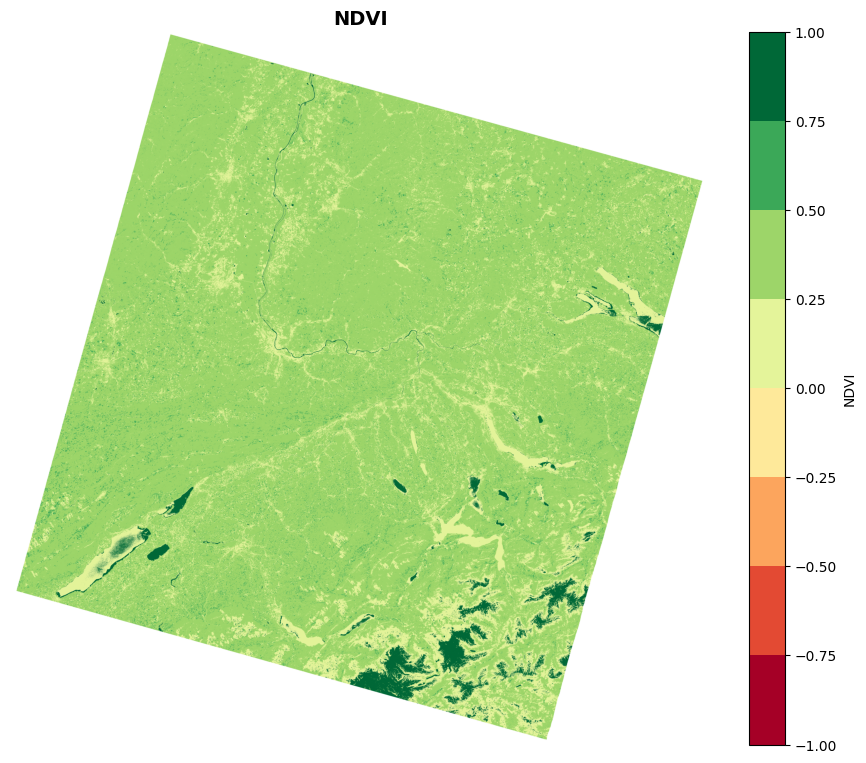

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Definieren der NIR (SR_B5) und Rot (SR_B4) Bänder aus den Satellitendaten
required_bandname_list = ['SR_B5', 'SR_B4']

stacked_data = []
for bandname in required_bandname_list:
    for file in file_list:
        if file['bandname'] == bandname:
            with rasterio.open(file['path']) as band_data:
                band_array = band_data.read(1)
                stacked_data.append(band_array)

# Berechnen des NDVI (Fügen Sie eine kleine Zahl zum Nenner hinzu, um eine Division durch Null zu vermeiden)
ndvi = (stacked_data[0]-stacked_data[1])/(stacked_data[0]+stacked_data[1]+1e-10)

ndvi_masked = np.ma.masked_where(ndvi ==0, ndvi)

# Plotten des NDVI
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('RdYlGn',8)
cmap.set_bad(color='white')

im = plt.imshow(ndvi_masked, cmap=cmap, vmin=-1, vmax=1)

# Hinzufügen einer Farbskala
plt.colorbar(im, fraction=0.046, label='NDVI')

# Setzen des Titels für den Plot
plt.title('NDVI', fontsize=14, fontweight='bold')

# Entfernen der Achsenticks für eine sauberere Anzeige
plt.axis('off')

# Anzeigen des Plots
plt.show()


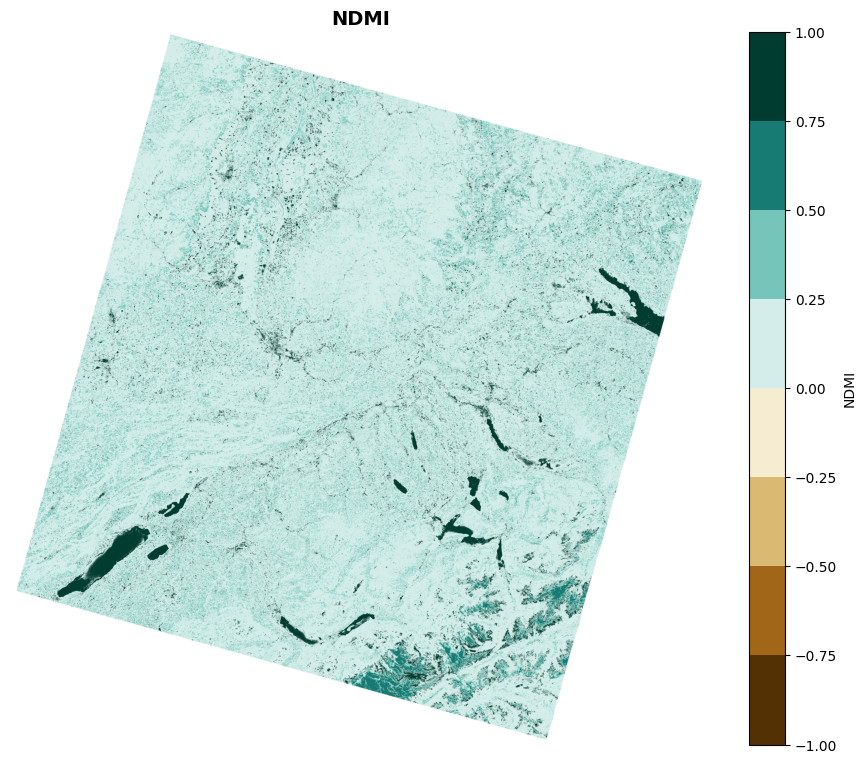

In [14]:
# Definieren der NIR (SR_B5) und SWIR (SR_B6) Bänder aus den Satellitendaten
required_bandname_list = ['SR_B5', 'SR_B6']

stacked_data = []
for bandname in required_bandname_list:
    for file in file_list:
        if file['bandname'] == bandname:
            with rasterio.open(file['path']) as band_data:
                band_array = band_data.read(1)
                stacked_data.append(band_array)

# Berechnen des NDMI (Fügen Sie eine kleine Zahl zum Nenner hinzu, um eine Division durch Null zu vermeiden)
ndmi = (stacked_data[0] - stacked_data[1]) / (stacked_data[0] + stacked_data[1] + 1e-10)

# Maskieren der Nullwerte für eine bessere Visualisierung
ndmi_masked = np.ma.masked_where(ndmi == 0, ndmi)

# Plotten des NDMI
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('BrBG', 8)
cmap.set_bad(color='white')

im = plt.imshow(ndmi_masked, cmap=cmap, vmin=-1, vmax=1)

# Hinzufügen einer Farbskala
plt.colorbar(im, fraction=0.046, label='NDMI')

# Setzen des Titels für den Plot
plt.title('NDMI', fontsize=14, fontweight='bold')

# Entfernen der Achsenticks für eine sauberere Anzeige
plt.axis('off')

# Anzeigen des Plots
plt.show()


## 5. Bodentemperatur

### 5.1 LST für den gesamten Datensatz plotten

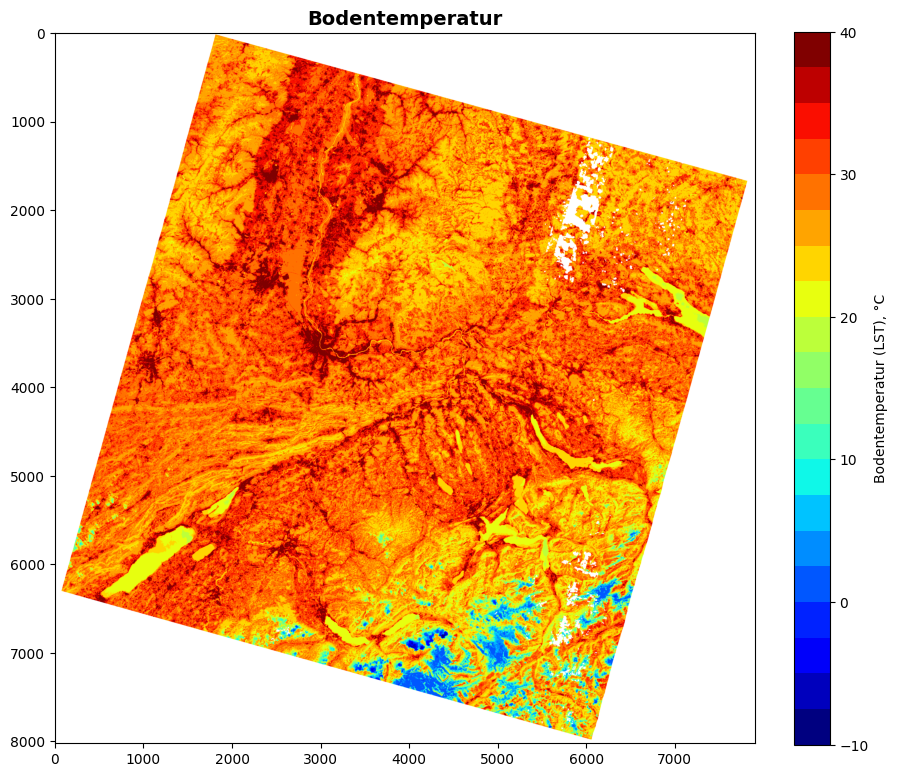

In [15]:
band_name = 'ST_B10'

for file in file_list:
    if file['bandname'] == band_name:
        with rasterio.open(file['path']) as band_data:
            no_data_value = band_data.nodata        
            band_data_array = band_data.read(1)

            # Maskierte Daten für fehlende Werte
            masked_data = np.where(np.isclose(band_data_array, no_data_value, atol=1e-5), np.nan, band_data_array)
            corrected_data = (masked_data * 0.00341802 + 149.0) - 273.15

# Plotten der LST
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('jet', 20)
cmap.set_bad(color='white')

im = plt.imshow(corrected_data, cmap=cmap, vmin=-10, vmax=40)
plt.colorbar(im, fraction=0.046, label='Bodentemperatur (LST), °C')
plt.title('Bodentemperatur', fontsize=14, fontweight='bold')
# plt.axis('off')
plt.show()


### 5.2 LST für den Interessenbereich zeichnen

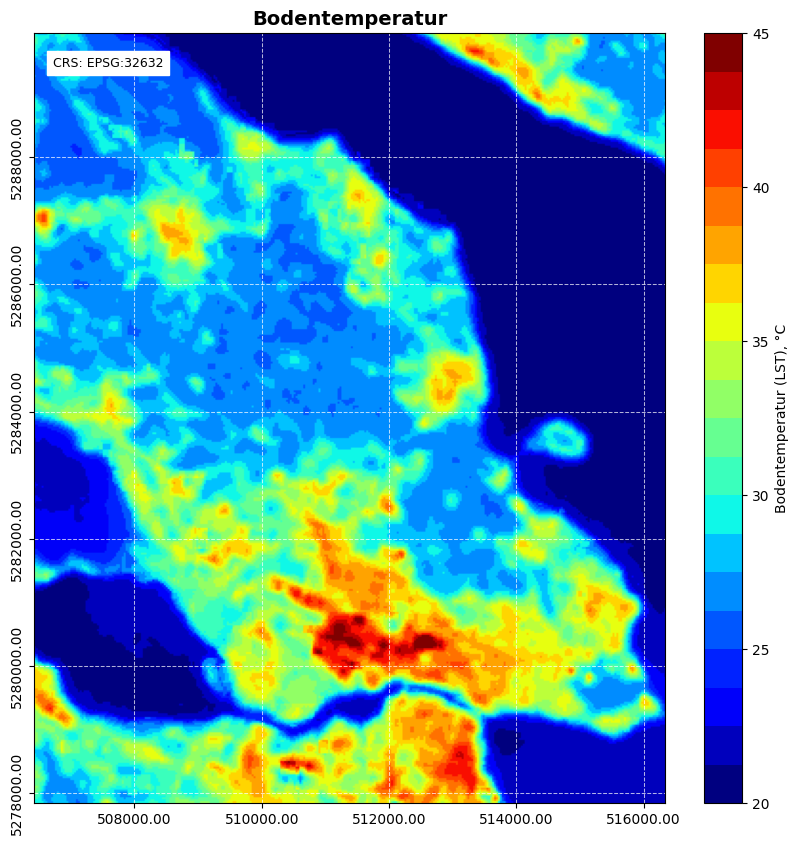

In [16]:
### 5.2 LST für das Interessengebiet plotten
import geopandas as gpd
from matplotlib import ticker
import matplotlib.transforms

from pyproj import Transformer
from rasterio.windows import from_bounds

# Laden der Shapefile von Konstanz (WGS84-Projektion) für geografische Grenzfilterung
shapefile = r"./shapefiles/kn_boundary.shp"
gdf = gpd.read_file(shapefile)

# Extrahieren der Begrenzungsbox und CRS der Shapefile
shapefile_bounds = gdf.total_bounds
shapefile_crs = gdf.crs

# Definieren des Ziel-CRS und des Transformers
with rasterio.open(file['path']) as band_data:
    target_crs = band_data.crs

# target_crs = "EPSG:32632"
transformer = Transformer.from_crs(shapefile_crs, target_crs, always_xy=True)

# Transformieren der Koordinaten für das Interessengebiet
minx, miny, maxx, maxy = shapefile_bounds
minx_new, miny_new = transformer.transform(minx, miny)
maxx_new, maxy_new = transformer.transform(maxx, maxy)
aoi_bounds = (minx_new, miny_new, maxx_new, maxy_new)

# Extrahieren der Banddaten für die LST-Berechnung und das Plotten
band_name = 'ST_B10'

for file in file_list:
    if file['bandname'] == band_name:
        with rasterio.open(file['path']) as band_data:
            # Extrahieren des NoData-Werts für die Maskierung
            no_data_value = band_data.nodata

            # Definieren des AOI-Fensters und Auslesen der Daten
            aoi_window = from_bounds(*aoi_bounds, transform=band_data.transform)
            band_data_array = band_data.read(1, window=aoi_window)
            
            # Maskieren von NoData-Werten
            masked_data = np.where(np.isclose(band_data_array, no_data_value, atol=1e-5),
                                   np.nan, band_data_array)
            
            # Anwendung der Korrekturen: https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-temperature
            corrected_data = (masked_data * 0.00341802 + 149.0) - 273.15
            
            # Berechnung des Transforms für das Fenster
            window_transform = band_data.window_transform(aoi_window)

# Plotten der Bodentemperatur (LST)
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('jet', 20)
cmap.set_bad(color='white')

# Definieren der Ausdehnung für das Bild
extent = (aoi_bounds[0], aoi_bounds[2], aoi_bounds[1], aoi_bounds[3])
im = ax.imshow(corrected_data, cmap=cmap, vmin=20, vmax=45, extent=extent)

# Hinzufügen einer Farbskala
plt.colorbar(im, fraction=0.05, label='Bodentemperatur (LST), °C')

# Formatieren der x- und y-Achsen-Ticks
def fmt_two_digits(axis, pos):
    return f'{axis:.2f}'
ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_two_digits))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(fmt_two_digits))

for label in ax.get_yticklabels():
    label.set_rotation(90)
    label.set_verticalalignment('center')

# Setzen des Titels für das Diagramm
plt.title('Bodentemperatur', fontsize=14, fontweight='bold')

# Hinzufügen eines Rasters
ax.grid(color='white', linestyle='--', linewidth=0.75, alpha=0.7)

# Hinzufügen von Text
text = (f"CRS: {target_crs}")

# Hinzufügen einer Beschreibung
plt.figtext(0.21, 0.85, text, ha='left', va='center', fontsize=9, backgroundcolor='w')

# Anzeige des Diagramms
plt.show()